In [1]:
import skimage

In [2]:
import gc

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut

from data import removeBackground, removePectoral
from data import (
    crop_medical_image,
    right_orient_mammogram,
    apply_canny,
    get_hough_lines,
    shortlist_lines,
    remove_pectoral_region,
    preprocess_images_task,
)

%matplotlib inline

In [3]:
file = '/home/rydevera3/data-science/kaggle/rsna-breast-cancer/data/train_images/10335/1792651296.dcm'
dicom = pydicom.dcmread(file)

In [4]:
dicom

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10335.1.1792651296
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10335.1.1792651296
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184124.883635'
(0010, 0020) Patient ID                          LO: '10335'
(0018, 11a0) Body Part Thickness                 DS: '47.0'
(0

In [5]:
dicom.pixel_array

array([[   0,    0,    0, ..., 1648, 2437, 2926],
       [   0,    0,    0, ..., 2254, 3175, 3526],
       [   0,    0,    0, ..., 3121, 3617, 3831],
       ...,
       [   0,    0,    0, ..., 3007, 3045, 3121],
       [   0,    0,    0, ..., 3022, 3042, 3042],
       [   0,    0,    0, ..., 2966, 2979, 3092]], dtype=uint16)

(array([6361153.,  701891.,  412458.,  292483.,  266959.,  210640.,
         150062.,   76423.,   28807.,   18804.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

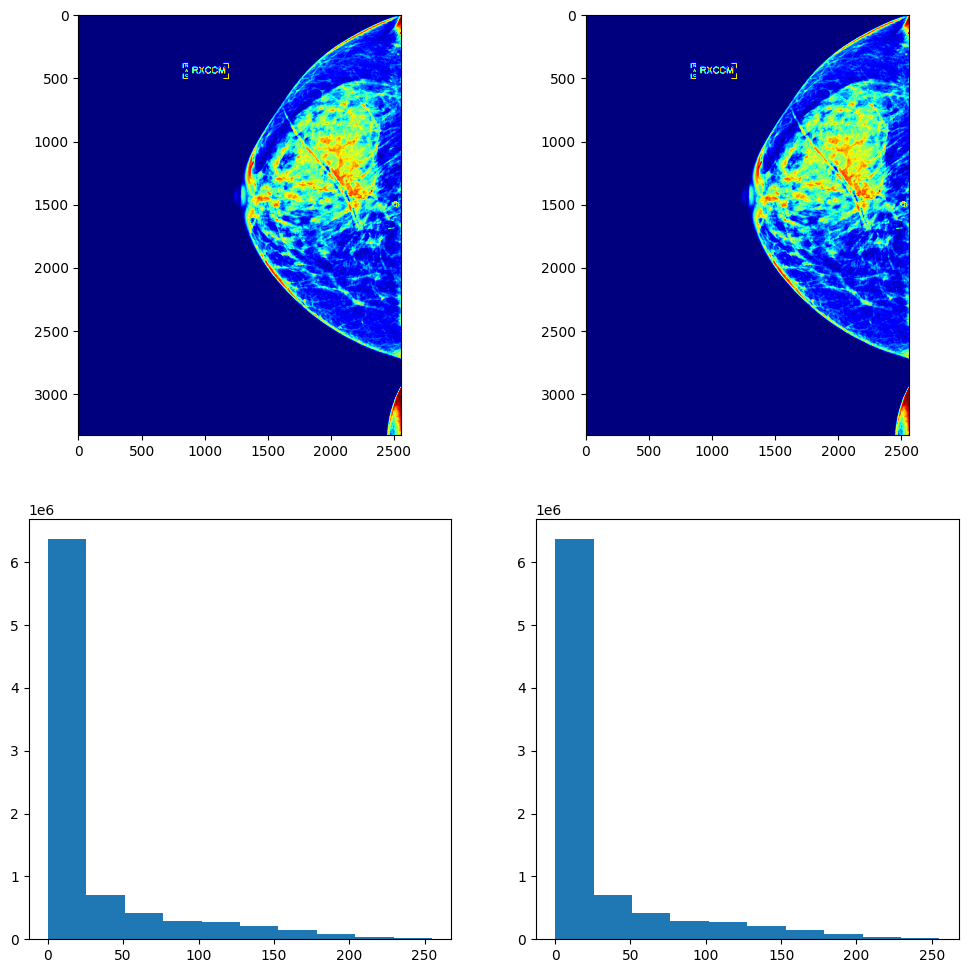

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

original_image = dicom.pixel_array
voi_lut_image = apply_voi_lut(dicom.pixel_array, dicom)

original_image = cv2.normalize(original_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_16UC1)
voi_lut_image = cv2.normalize(voi_lut_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_16UC1)

# # Scale images
# original_image = (
#     (original_image - original_image.min()) / (original_image.max() - original_image.min())
# )

if dicom.PhotometricInterpretation == 'MONOCHROME1':
    original_image = 255 - original_image
    voi_lut_image = 255 - voi_lut_image

# voi_lut_image = (
#     (voi_lut_image - voi_lut_image.min()) / (voi_lut_image.max() - voi_lut_image.min())
# )
# voi_lut_image = 1 - voi_lut_image

ax1 = axes[0]
ax1.imshow(original_image, cmap='jet')

ax2 = axes[1]
ax2.imshow(voi_lut_image, cmap='jet')

ax3 = axes[2]
ax3.hist(original_image.flatten())

ax4 = axes[3]
ax4.hist(voi_lut_image.flatten())

# Create the cleaned images

In [7]:
from data import removeBackground, removePectoral
from data import crop_medical_image, right_orient_mammogram, apply_canny, get_hough_lines, shortlist_lines, remove_pectoral_region

#Preprocess Image
#Recommended variable values
#ball_size = 5
#erosion_size = (4,2)
#erosion_iterations = 1
#dilation_size = (3,2)
#dilation_iterations = 6

image = crop_medical_image(voi_lut_image, output_size=(240, 384), threshold=45)
X = image.copy()

image_remove_background = removeBackground(
    X,
    ball_size=5,
    erosion_size=(4, 2),
    erosion_iterations=1,
    dilation_size=(3, 2),
    dilation_iterations=6,
)
image_remove_background = right_orient_mammogram(image_remove_background.copy())

image_remove_pectoral = removePectoral(image_remove_background.copy())

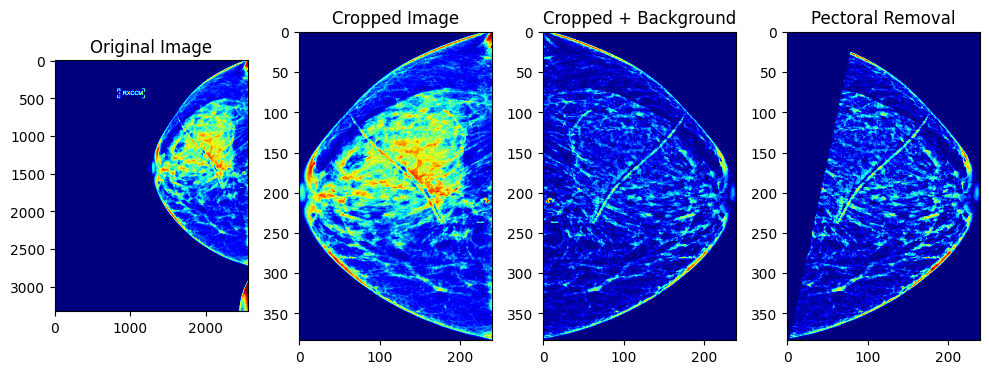

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 7))

ax1.imshow(voi_lut_image, cmap='jet')
ax1.set_title('Original Image')

ax2.imshow(image, cmap='jet')
ax2.set_title('Cropped Image')

ax3.imshow(image_remove_background, cmap='jet')
ax3.set_title('Cropped + Background')

ax4.imshow(image_remove_pectoral, cmap='jet')
ax4.set_title('Pectoral Removal')

fig.tight_layout()